In [1]:
# Limit usage to GPU 1
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [2]:
# Path to pre-partitioned data
SPLITS = os.path.abspath('splits_20test_5inner.pkl')
ADNI2 = os.path.abspath('adni2_validation.pkl')
FEATURES = 32
FOLDS = 5

In [3]:
import pickle
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow_probability import layers as tfplayers
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import util as tfu
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Subject random effects

In [4]:
# Load partitioned data 
with open(SPLITS, 'rb') as f:
    dictSplits = pickle.load(f)

with open(ADNI2, 'rb') as f:
    dfDataAdni2, dfLabelsAdni2 = pickle.load(f)

def cross_validate(model_fn, design_matrix=True , plot=False):
    # Train and evaluate a model for each cross-validation fold. Use subject IDs to specify random effects.
    # args:
    #   model_fn:   function that generations a keras model (see cell below)
    #   design_matrix: set to False if training a fixed effects model that requires no design matrix
    #   plot:       whether to plot random effects distributions
    arrAUROC = np.zeros((FOLDS,))
    for iFold in range(FOLDS):
        # train and validate a model across K-Folds
        dfDataTrain, dfLabelsTrain = dictSplits['train' + str(iFold)]
        dfDataVal, dfLabelsVal = dictSplits['val' + str(iFold)]
            
        # Do some preprocessing: scale to 0M1V, impute missing values
        preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
        arrXTrain = preproc.fit_transform(dfDataTrain.astype(float))
        arrXVal = preproc.transform(dfDataVal.astype(float))
        arrYTrain = dfLabelsTrain.values.astype(np.float32)
        arrYVal = dfLabelsVal.values.astype(np.float32)

        if design_matrix:
            # Create the design matrix by one-hot encoding the subject labels
            onehot = OneHotEncoder(drop=None, sparse=False)
            arrSubjectIDs = np.array(dfDataTrain.index.get_level_values(0))
            arrDesignTrain = onehot.fit_transform(arrSubjectIDs.reshape(-1, 1))

            # Create dummy design matrix for validation data
            arrDesignVal = np.zeros((arrXVal.shape[0], arrDesignTrain.shape[1]))
            lsInputsTrain = [arrXTrain, arrDesignTrain]
            lsInputsVal = [arrXVal, arrDesignVal]
            model = model_fn(arrDesignTrain.shape[1])

        else:
            lsInputsTrain = [arrXTrain]
            lsInputsVal = [arrXVal]
            model = model_fn()
        model.fit(lsInputsTrain, arrYTrain,
                validation_data=(lsInputsVal, arrYVal),
                batch_size=32,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_auroc', mode='max', patience=5, restore_best_weights=True)],
                epochs=100)
        arrAUROC[iFold] = model.evaluate(lsInputsVal, arrYVal)[1]
        if design_matrix & plot:
            # plot some weights
            fig, ax = plt.subplots(1, len(model.get_layer('RE').weights))
            for i, weight in enumerate(model.get_layer('RE').weights):
                ax[i].hist(weight.numpy())
                ax[i].set_xlabel(weight.name)
            plt.show()
        del model

    return arrAUROC

def test_model(model_fn, design_matrix=True):
    dfDataTrain, dfLabelsTrain = dictSplits['trainval']
    dfDataTest, dfLabelsTest = dictSplits['test']
        
    # Do some preprocessing: scale to 0M1V, impute missing values
    preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
    arrXTrain = preproc.fit_transform(dfDataTrain.astype(float))
    arrXTest = preproc.transform(dfDataTest.astype(float))
    arrXAdni2 = preproc.transform(dfDataAdni2.astype(float))
    arrYTrain = dfLabelsTrain.values.astype(np.float32)
    arrYTest = dfLabelsTest.values.astype(np.float32)
    arrYAdni2 = dfLabelsAdni2.values.astype(np.float32)

    if design_matrix:
        # Create the design matrix by one-hot encoding the subject labels
        onehot = OneHotEncoder(drop=None, sparse=False)
        arrSubjectIDs = np.array(dfDataTrain.index.get_level_values(0))
        arrDesignTrain = onehot.fit_transform(arrSubjectIDs.reshape(-1, 1))

        # Create dummy design matrix for test data and ADNI2
        arrDesignTest = np.zeros((arrXTest.shape[0], arrDesignTrain.shape[1]))
        arrDesignAdni2 = np.zeros((arrXAdni2.shape[0], arrDesignTrain.shape[1]))

        lsInputsTrain = [arrXTrain, arrDesignTrain]
        lsInputsTest = [arrXTest, arrDesignTest]
        lsInputsAdni2 = [arrXAdni2, arrDesignAdni2]
        model = model_fn(arrDesignTrain.shape[1])

    else:
        lsInputsTrain = [arrXTrain]
        lsInputsTest = [arrXTest]
        lsInputsAdni2 = [arrXAdni2]
        model = model_fn()

    model.fit(lsInputsTrain, arrYTrain,
        validation_data=(lsInputsTest, arrYTest),
        batch_size=32,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping('val_auroc', mode='max', patience=5, restore_best_weights=True)],
        epochs=100)
    fAUROCTest = model.evaluate(lsInputsTest, arrYTest, verbose=0)[1]
    fAUROCAdni2 = model.evaluate(lsInputsAdni2, arrYAdni2, verbose=0)[1]
    return fAUROCTest, fAUROCAdni2

Best conventional FFNN architecture found through BOHB search. Will use this as the base of the mixed effects models.

{'activation': 'LeakyReLU', 'batchnorm': False, 'beta_1': 0.3196264092111109, 'beta_2': 0.8235759591723694, 'dense0_neurons': 72, 'dropout': 0.40227964526394644, 'hiddenlayers': 1, 'l1': 0.5561272951811257, 'l2': 0.513440074084923, 'lr': 0.010229000826894694, 'taper': 0.4297025899081944}

In [5]:
# Functions for generating various models
def create_fixed_model():
    # Create conventional model based on the architecture above
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.556, l2=0.513)   
    h = tf.keras.layers.Dense(72, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.LeakyReLU()(h)
    h = tf.keras.layers.Dropout(0.402)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    output = tf.keras.layers.Activation('sigmoid')(fe)

    model = tf.keras.models.Model([inputX], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.010, beta_1=0.320, beta_2=0.824)

    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

def posterior_fn(dtype, shape, name, trainable, add_variable_fn):
    loc_scale_fn = tfplayers.default_loc_scale_fn()
    loc = add_variable_fn(name=name + '_loc',
                        shape=shape,
                        initializer=tf.initializers.random_uniform(minval=-1.0, maxval=1.0),
                        dtype=dtype,
                        trainable=trainable)

    untransformed_scale = add_variable_fn(name=name + '_untransformed_scale',
                                        shape=[1],
                                        initializer=tf.initializers.random_uniform(minval=0.01, maxval=1.0),
                                        dtype=dtype,
                                        trainable=trainable)
    scale = tfu.DeferredTensor(untransformed_scale,
                                    lambda x: (np.finfo(dtype.as_numpy_dtype).eps + tf.nn.softplus(x)))
    dist = tfd.Normal(loc=loc, scale=scale)
    batch_ndims = tf.size(dist.batch_shape_tensor())
    return tfd.Independent(dist, reinterpreted_batch_ndims=batch_ndims)

def create_random_intercept_model(nRandomGroups):
    # This model takes a design matrix as an additional input, which goes into a probabilistic dense layer
    # This layer's output is added to the fixed effects output, functioning as an intercept
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.556, l2=0.513)   
    h = tf.keras.layers.Dense(72, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.LeakyReLU()(h)
    h = tf.keras.layers.Dropout(0.402)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    inputZ = tf.keras.layers.Input((nRandomGroups, ), name='Z')
    re = tfplayers.DenseFlipout(1, 
                                kernel_posterior_fn=posterior_fn, 
                                kernel_posterior_tensor_fn=(lambda d: tf.math.reduce_mean(d.sample(100), axis=0)),
                                name='RE')(inputZ)

    # Add fixed and random effects together
    mix = tf.keras.layers.Add()([fe, re])
    output = tf.keras.layers.Activation('sigmoid')(mix)

    model = tf.keras.models.Model([inputX, inputZ], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.010, beta_1=0.320, beta_2=0.824)

    # Loss function is sum of binary_crossentropy and KL divergence of the probabilistic layer
    # However, Keras should automatically add in the KL divergence
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

def create_random_slope_model(nRandomGroups):
    # This model takes a design matrix as an additional input, which goes into a probabilistic dense layer
    # This layer's output is added to the fixed effects output, functioning as an intercept
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.556, l2=0.513)   
    h = tf.keras.layers.Dense(72, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.LeakyReLU()(h)
    h = tf.keras.layers.Dropout(0.402)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    inputZ = tf.keras.layers.Input((nRandomGroups, ), name='Z')
    concat = tf.keras.layers.Concatenate()([fe, inputZ])
    re = tfplayers.DenseFlipout(1, 
                                kernel_posterior_fn=posterior_fn, 
                                kernel_posterior_tensor_fn=(lambda d: tf.math.reduce_mean(d.sample(100), axis=0)),
                                name='RE')(concat)

    # Add fixed and random effects together
    mix = tf.keras.layers.Add()([fe, re])
    output = tf.keras.layers.Activation('sigmoid')(mix)

    model = tf.keras.models.Model([inputX, inputZ], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.010, beta_1=0.320, beta_2=0.824)

    # Loss function is sum of binary_crossentropy and KL divergence of the probabilistic layer
    # However, Keras should automatically add in the KL divergence
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model

def create_random_slope_intercept_model(nRandomGroups):
    # This model takes a design matrix as an additional input, which goes into a probabilistic dense layer
    # This layer's output is added to the fixed effects output, functioning as an intercept
    inputX = tf.keras.layers.Input((FEATURES, ), name='X')
    reg = tf.keras.regularizers.L1L2(l1=0.556, l2=0.513)   
    h = tf.keras.layers.Dense(72, kernel_regularizer=reg)(inputX)
    h = tf.keras.layers.LeakyReLU()(h)
    h = tf.keras.layers.Dropout(0.402)(h)
    fe = tf.keras.layers.Dense(1, activation='linear', name='FE')(h)

    inputZ = tf.keras.layers.Input((nRandomGroups, ), name='Z')
    concat = tf.keras.layers.Concatenate()([fe, inputZ])
    reSlope = tfplayers.DenseFlipout(1, 
                                kernel_posterior_fn=posterior_fn, 
                                kernel_posterior_tensor_fn=(lambda d: tf.math.reduce_mean(d.sample(100), axis=0)),
                                name='RE_slope')(concat)
    reInt =  tfplayers.DenseFlipout(1, 
                                kernel_posterior_fn=posterior_fn, 
                                kernel_posterior_tensor_fn=(lambda d: tf.math.reduce_mean(d.sample(100), axis=0)),
                                name='RE_int')(inputZ)                               

    # Add fixed and random effects together
    mix = tf.keras.layers.Add()([fe, reSlope, reInt])
    output = tf.keras.layers.Activation('sigmoid')(mix)

    model = tf.keras.models.Model([inputX, inputZ], output)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.010, beta_1=0.320, beta_2=0.824)

    # Loss function is sum of binary_crossentropy and KL divergence of the probabilistic layer
    # However, Keras should automatically add in the KL divergence
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc')])

    return model


In [6]:
arrAUROCFixed = cross_validate(create_fixed_model, design_matrix=False)
print(arrAUROCFixed.mean())

6/6 [==============================] - 0s 2ms/step - loss: 9.5763 - auroc: 0.8027
0.8095838069915772


In [7]:
arrAUROCRandomInt = cross_validate(create_random_intercept_model, design_matrix=True)
print(arrAUROCRandomInt.mean())

Instructions for updating:
Please use `layer.add_weight` method instead.
6/6 [==============================] - 0s 3ms/step - loss: 14.6965 - auroc: 0.8382
0.8432095289230347


In [8]:
arrAUROCRandomSlope = cross_validate(create_random_slope_model, design_matrix=True)
print(arrAUROCRandomSlope.mean())

6/6 [==============================] - 0s 3ms/step - loss: 14.1874 - auroc: 0.7734
0.8217962503433227


In [9]:
arrAUROCRandomSlopeInt = cross_validate(create_random_slope_intercept_model, design_matrix=True)
print(arrAUROCRandomSlopeInt.mean())

6/6 [==============================] - 0s 3ms/step - loss: 6.7155 - auroc: 0.7810
0.803488802909851


Text(0, 0.5, 'AUROC')

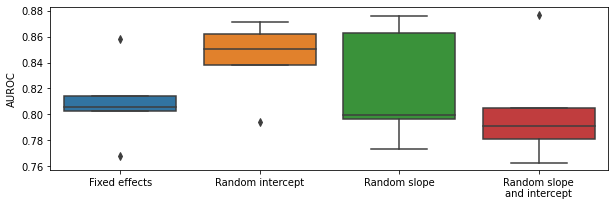

In [10]:
df = pd.DataFrame(np.vstack([arrAUROCFixed, arrAUROCRandomInt, arrAUROCRandomSlope, 
                             arrAUROCRandomSlopeInt]),
                    index=['Fixed effects', 'Random intercept', 'Random slope', 
                            'Random slope\nand intercept'])
# dfLong = pd.melt(df.T, value_name='AUROC', var_name='Model') 
fig, ax = plt.subplots(figsize=(10, 3))                 
sns.boxplot(data=df.T, ax=ax)
ax.set_ylabel('AUROC')


In [11]:
# Perform some paired t-tests between each model and the baseline fixed effects model
import scipy.stats
for strModel in df.index[1:]:
    t, p = scipy.stats.ttest_rel(df.loc['Fixed effects'], df.loc[strModel])
    print(strModel, f't = {t:.03f}, p = {p:.03f}')

Random intercept t = -5.447, p = 0.006
Random slope t = -0.764, p = 0.487
Random slope
and intercept t = 0.788, p = 0.475


In [22]:
# Let's check test performance and external validation on ADNI2
dfTest = pd.DataFrame(columns=['Test', 'ADNI2'])
dfTest.loc['Fixed effects'] = test_model(create_fixed_model, design_matrix=False)
dfTest.loc['Random intercept'] = test_model(create_random_intercept_model)
dfTest.loc['Random slope'] = test_model(create_random_slope_model)
dfTest.loc['Random slope\nand intercept'] = test_model(create_random_slope_intercept_model)

(0.73, 0.88)

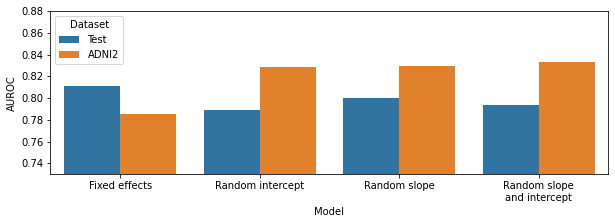

In [23]:
dfTestLong = pd.melt(dfTest, var_name='Dataset', value_name='AUROC', ignore_index=False)
dfTestLong['Model'] = dfTestLong.index
fig, ax = plt.subplots(figsize=(10, 3))    
sns.barplot(data=dfTestLong, x='Model', y='AUROC', hue='Dataset', ax=ax)
ax.set_ylim(0.73, 0.88)

# Site random effects

In [14]:
def cross_validate_siteeffect(model_fn, design_matrix=True , plot=False):
    # Train and evaluate a model for each cross-validation fold. Use site IDs to specify random effects.
    # args:
    #   model_fn:   function that generations a keras model (see cell below)
    #   design_matrix: set to False if training a fixed effects model that requires no design matrix
    #   plot:       whether to plot random effects distributions
    arrAUROC = np.zeros((FOLDS,))
    for iFold in range(FOLDS):
        # train and validate a model across K-Folds
        dfDataTrain, dfLabelsTrain = dictSplits['train' + str(iFold)]
        dfDataVal, dfLabelsVal = dictSplits['val' + str(iFold)]
            
        # Do some preprocessing: scale to 0M1V, impute missing values
        preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
        arrXTrain = preproc.fit_transform(dfDataTrain.astype(float))
        arrXVal = preproc.transform(dfDataVal.astype(float))
        arrYTrain = dfLabelsTrain.values.astype(np.float32)
        arrYVal = dfLabelsVal.values.astype(np.float32)

        if design_matrix:
            # Each subject's site is indicated by the first 3 digits of their ID, e.g. <site number>_S_<subject id>
            arrSiteTrain = np.array([x.split('_')[0] for x in dfDataTrain.index.get_level_values(0)])
            arrSiteVal = np.array([x.split('_')[0] for x in dfDataVal.index.get_level_values(0)])

            # Create the design matrix by one-hot encoding the site labels
            onehot = OneHotEncoder(drop=None, sparse=False)
            arrDesignTrain = onehot.fit_transform(arrSiteTrain.reshape(-1, 1))
            # arrDesignVal = onehot.transform(arrSiteVal.reshape(-1, 1))
            arrDesignVal = np.zeros((arrXVal.shape[0], arrDesignTrain.shape[1]))

            lsInputsTrain = [arrXTrain, arrDesignTrain]
            lsInputsVal = [arrXVal, arrDesignVal]
            model = model_fn(arrDesignTrain.shape[1])

        else:
            lsInputsTrain = [arrXTrain]
            lsInputsVal = [arrXVal]
            model = model_fn()
        model.fit(lsInputsTrain, arrYTrain,
                validation_data=(lsInputsVal, arrYVal),
                batch_size=32,
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_auroc', mode='max', patience=5, restore_best_weights=True)],
                epochs=100)
        arrAUROC[iFold] = model.evaluate(lsInputsVal, arrYVal)[1]
        if design_matrix & plot:
            # plot some weights
            fig, ax = plt.subplots(1, len(model.get_layer('RE').weights))
            for i, weight in enumerate(model.get_layer('RE').weights):
                ax[i].hist(weight.numpy())
                ax[i].set_xlabel(weight.name)
            plt.show()
        del model

    return arrAUROC

def test_model_siteeffect(model_fn, design_matrix=True):
    dfDataTrain, dfLabelsTrain = dictSplits['trainval']
    dfDataTest, dfLabelsTest = dictSplits['test']
        
    # Do some preprocessing: scale to 0M1V, impute missing values
    preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
    arrXTrain = preproc.fit_transform(dfDataTrain.astype(float))
    arrXTest = preproc.transform(dfDataTest.astype(float))
    arrXAdni2 = preproc.transform(dfDataAdni2.astype(float))
    arrYTrain = dfLabelsTrain.values.astype(np.float32)
    arrYTest = dfLabelsTest.values.astype(np.float32)
    arrYAdni2 = dfLabelsAdni2.values.astype(np.float32)

    if design_matrix:
        arrSiteTrain = np.array([x.split('_')[0] for x in dfDataTrain.index.get_level_values(0)])

        # Create the design matrix by one-hot encoding the site labels
        onehot = OneHotEncoder(drop=None, sparse=False)
        arrDesignTrain = onehot.fit_transform(arrSiteTrain.reshape(-1, 1))

        # Create dummy design matrix for test data and ADNI2
        arrDesignTest = np.zeros((arrXTest.shape[0], arrDesignTrain.shape[1]))
        arrDesignAdni2 = np.zeros((arrXAdni2.shape[0], arrDesignTrain.shape[1]))

        lsInputsTrain = [arrXTrain, arrDesignTrain]
        lsInputsTest = [arrXTest, arrDesignTest]
        lsInputsAdni2 = [arrXAdni2, arrDesignAdni2]
        model = model_fn(arrDesignTrain.shape[1])

    else:
        lsInputsTrain = [arrXTrain]
        lsInputsTest = [arrXTest]
        lsInputsAdni2 = [arrXAdni2]
        model = model_fn()

    model.fit(lsInputsTrain, arrYTrain,
        validation_data=(lsInputsTest, arrYTest),
        batch_size=32,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping('val_auroc', mode='max', patience=5, restore_best_weights=True)],
        epochs=100)
    fAUROCTest = model.evaluate(lsInputsTest, arrYTest, verbose=0)[1]
    fAUROCAdni2 = model.evaluate(lsInputsAdni2, arrYAdni2, verbose=0)[1]
    return fAUROCTest, fAUROCAdni2



In [15]:
arrAUROCSiteInt = cross_validate_siteeffect(create_random_intercept_model, design_matrix=True)
print(arrAUROCSiteInt.mean())

6/6 [==============================] - 0s 2ms/step - loss: 7.8134 - auroc: 0.8443
0.8253252267837524


In [16]:
arrAUROCSiteSlope = cross_validate_siteeffect(create_random_slope_model, design_matrix=True)
print(arrAUROCSiteSlope.mean())

6/6 [==============================] - 0s 2ms/step - loss: 7.0961 - auroc: 0.8002
0.790403938293457


In [17]:
arrAUROCSiteSlopeInt = cross_validate_siteeffect(create_random_slope_intercept_model, design_matrix=True)
print(arrAUROCSiteSlopeInt.mean())

6/6 [==============================] - 0s 3ms/step - loss: 18.3916 - auroc: 0.7773
0.8199797153472901


Text(0, 0.5, 'AUROC')

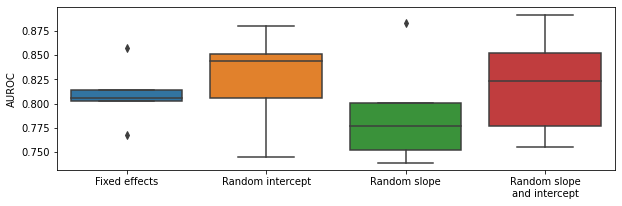

In [18]:
df = pd.DataFrame(np.vstack([arrAUROCFixed, arrAUROCSiteInt, arrAUROCSiteSlope, 
                             arrAUROCSiteSlopeInt]),
                    index=['Fixed effects', 'Random intercept', 'Random slope', 
                            'Random slope\nand intercept'])
fig, ax = plt.subplots(figsize=(10, 3))                 
sns.boxplot(data=df.T, ax=ax)
ax.set_ylabel('AUROC')


In [19]:
for strModel in df.index[1:]:
    t, p = scipy.stats.ttest_rel(df.loc['Fixed effects'], df.loc[strModel])
    print(strModel, f't = {t:.03f}, p = {p:.03f}')

Random intercept t = -1.295, p = 0.265
Random slope t = 1.150, p = 0.314
Random slope
and intercept t = -0.817, p = 0.460


In [20]:
# Let's check test performance and external validation on ADNI2
dfTest = pd.DataFrame(columns=['Test', 'ADNI2'])
dfTest.loc['Fixed effects'] = test_model_siteeffect(create_fixed_model, design_matrix=False)
dfTest.loc['Random intercept'] = test_model_siteeffect(create_random_intercept_model)
dfTest.loc['Random slope'] = test_model_siteeffect(create_random_slope_model)
dfTest.loc['Random slope\nand intercept'] = test_model_siteeffect(create_random_slope_intercept_model)

(0.75, 0.84)

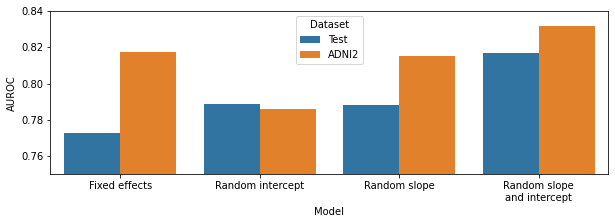

In [21]:
dfTestLong = pd.melt(dfTest, var_name='Dataset', value_name='AUROC', ignore_index=False)
dfTestLong['Model'] = dfTestLong.index
fig, ax = plt.subplots(figsize=(10, 3))    
sns.barplot(data=dfTestLong, x='Model', y='AUROC', hue='Dataset', ax=ax)
ax.set_ylim(0.75, 0.84)